In [153]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import layers

In [154]:
print(tf.__version__)

2.3.0


In [155]:
#from google.colab import drive
#rive.mount('/content/drive')

In [156]:
## mozda zatreba ako je problem u ekstenzijama datoteka
#import imghdr     
#for file in image_file_list:    
#image = cv2.imread(file)
#file_type = imghdr.what(file)  
#if file_type != 'jpeg':  
#    print(file +  " - invalid - " +  str(file_type))  
#    cv2.imwrite(file, image)

In [157]:
import pathlib
#data_dir = pathlib.Path("slike_namjestaja")
train_dir = pathlib.Path("../input/furniture-detector/img/train")
test_dir = pathlib.Path("../input/furniture-detector/img/val")

In [158]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

4024


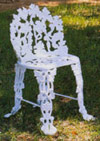

In [159]:
chair = list(train_dir.glob('chair/*'))
# Get the jpg files then sort them
chair_sort = sorted(chair)
PIL.Image.open(str(chair_sort[2]))

In [160]:
batch_size = 32
img_height = 200
img_width = 200

In [161]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  #validation_split=0.05,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4024 files belonging to 5 classes.


In [162]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  #validation_split=0.05,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 423 files belonging to 5 classes.


In [163]:
class_names = train_ds.class_names
print(class_names)

['bed', 'chair', 'sofa', 'swivelchair', 'table']


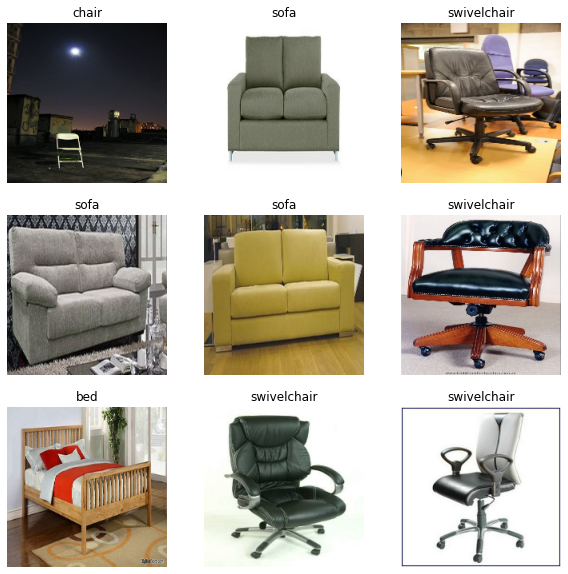

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [165]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  
  break

(32, 200, 200, 3)
(32,)


In [166]:
from tensorflow.keras import layers

#normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [167]:
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [168]:
## Ako treba moze se koristiti data ugmentation da se poveca broj slika za trening, ideja je da augmentation 
## rotira postojece slike i takve opet koristi za trening
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [169]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [170]:
num_classes = len(class_names)

## arhitektura modela:
inputs = layers.Input(shape=(img_height, img_width, 3) )
inputs1 = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
h1 = layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(inputs1)
d1 = layers.MaxPooling2D()(h1)
d1 = layers.BatchNormalization()(d1)
d1 = layers.ReLU()(d1)
d1 = layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(d1)
d1 = layers.BatchNormalization()(d1)
d1 = layers.ReLU()(d1)
d1 = layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(d1)
d1 = layers.MaxPooling2D()(d1)
d1 = layers.BatchNormalization()(d1)
d1 = layers.ReLU()(d1)
h2 = layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(d1)
h2 = layers.MaxPooling2D()(h2)
h2 = layers.BatchNormalization()(h2)
h2 = layers.ReLU()(h2)
h3 = layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(h2)
h3 = layers.MaxPooling2D()(h3)
h3 = layers.BatchNormalization()(h3)
h3 = layers.ReLU()(h3)
h4 = layers.Conv2D(64, 3, kernel_regularizer=tf.keras.regularizers.L2(0.01))(h3)
h4 = layers.MaxPooling2D()(h4)
h4 = layers.BatchNormalization()(h4)
h4 = layers.ReLU()(h4)
h4 = layers.Conv2D(64, 2, kernel_regularizer=tf.keras.regularizers.L2(0.01))(h4)
h4 = layers.BatchNormalization()(h4)
h4 = layers.ReLU()(h4)

h4 = layers.Flatten()(h4)
h4 = layers.Dropout(0.4)(h4)
h4 = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.1),
    activity_regularizer=tf.keras.regularizers.L2(0.1))(h4)

out = layers.Dense(num_classes, activation = 'softmax')(h4)
model = tf.keras.Model(inputs, out)
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 99, 99, 32)        128       
_________________________________________________________________
re_lu_49 (ReLU)              (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 97, 97, 32)      

In [171]:
## kompajliranje modela
optim = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(
  optimizer=optim,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [172]:
## definiramo callback za brzinu učenja
def scheduler(epoch):
    if epoch < 20:
        return 0.001
    else:
        return 0.0001

from tensorflow.keras import callbacks
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [173]:
## treniranje neuronske mreze
no_epoch = 150

history = model.fit(
  train_ds,  ## nedostaju labele
  #validation_split=0.1,
  shuffle = True,
  epochs=no_epoch,
  callbacks = [callback]
)

Epoch 1/150
126/126 [==============================] - 9s 75ms/step - loss: 21.1715 - accuracy: 0.3004
Epoch 2/150
126/126 [==============================] - 3s 23ms/step - loss: 4.3864 - accuracy: 0.3598
Epoch 3/150
126/126 [==============================] - 3s 23ms/step - loss: 3.4889 - accuracy: 0.3546
Epoch 4/150
126/126 [==============================] - 3s 23ms/step - loss: 3.1821 - accuracy: 0.3688
Epoch 5/150
126/126 [==============================] - 3s 23ms/step - loss: 2.9011 - accuracy: 0.4130
Epoch 6/150
126/126 [==============================] - 3s 23ms/step - loss: 2.6174 - accuracy: 0.5490
Epoch 7/150
126/126 [==============================] - 3s 24ms/step - loss: 2.3813 - accuracy: 0.6305
Epoch 8/150
126/126 [==============================] - 3s 24ms/step - loss: 2.1826 - accuracy: 0.6660
Epoch 9/150
126/126 [==============================] - 3s 23ms/step - loss: 2.0092 - accuracy: 0.6988
Epoch 10/150
126/126 [==============================] - 3s 23ms/step - loss: 1.86

In [174]:
## testing model
prediction = model.predict(test_ds)
model.evaluate(test_ds)

14/14 [==============================] - 0s 10ms/step - loss: 1.0345 - accuracy: 0.9385


[1.034539818763733, 0.9385342597961426]

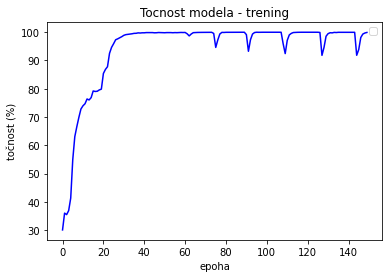

In [175]:
#model.save('20200918_94posto_acc.h5')
## crtanje funkcije gubitka
#print(history.history.keys())
# summarize history for accuracy
x = range(no_epoch)
y = np.array(history.history['accuracy'])*100

plt.plot(x, y, 'b')
#plt.plot(history.history['val_loss'], 'r', label = 'validation_loss')
plt.title('Tocnost modela - trening')
plt.ylabel('točnost (%)')
plt.xlabel('epoha')
#plt.yscale('log')
plt.legend()
plt.show()

Found 423 files belonging to 5 classes.
423


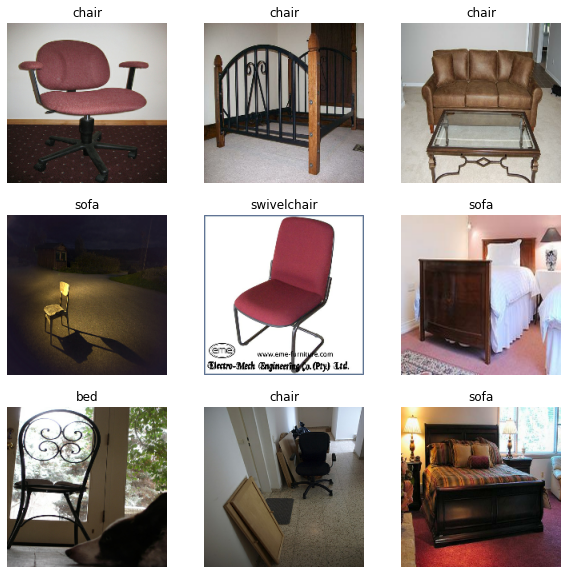

In [176]:
################# ANALIZA
# potrazimo pogreno interpretirane slike od strane neuronske mreze

## batch je problem u analizi pa ponovno učitavamo slike, ali bez batcha (sve su unutar jednog batcha)
## poredak nije isti po pokretanju celije, pa cemo za svaku sliku raditi predict modela za svaku sliku i analizirati
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  #validation_split=0.05,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=423)

# varijable
br = 0                      # counter
br_no = 0
test_len = len(list(test_dir.glob('*/*.jpg')))
print(test_len)

batch_no = 0
pred =[]
i = 0

# inicijaliziramo matricu koja ce na mjestu (i, j) imati broj previđanja NN da je klasa i zapravo klasa j
# to znači da su na dijagonali broj ispravnih predviđanja, a izvan dijagonale pogrešna predviđanja
# no dobra stvar je da znamo za svaku klasu i s čime ju mreža miješa i koliko puta - moze pomoci u poboljsanju modela
matrix = np.zeros((5, 5))  # confusion matrix

plt.figure(figsize=(10, 10))
for images, labels in test_ds:
        for i in range(test_len):
            image = tf.reshape(images[i], (1,img_height,img_width, 3))
            pred = model.predict(image)
            matrix[labels[i], np.argmax(pred)] = matrix[labels[i], np.argmax(pred)]+1
            ## crtamo prvih 6 pogreno interpretiranih slika            
            if np.argmax(pred) != labels[i]:
                if br+1 < 10:
                    ax = plt.subplot(3, 3, br+1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    plt.title(class_names[np.argmax(pred)])
                    plt.axis("off")
                br = br+1
            br_no = br_no+1


    ## zbog slucajnog odabira parametara u pocetku, moguce je s istom arhitekturom dobiti različit broj pogresnih primjera

Found 423 files belonging to 5 classes.
423


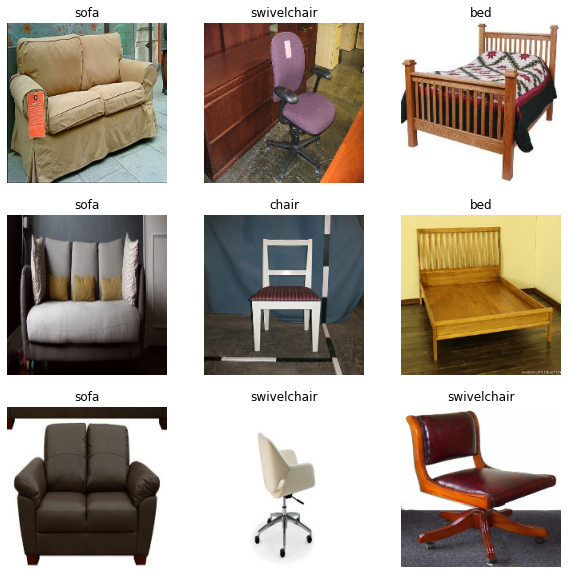

In [177]:
################# analiza
# potrazimo pogreno interpretirane slike od strane neuronske mreze

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  #validation_split=0.05,
  #subset="validation",
  seed=29255,
  image_size=(img_height, img_width),
  batch_size=423)

# varijable
br = 0                      # counter
br_no = 0
test_len = len(list(test_dir.glob('*/*.jpg')))
print(test_len)

batch_no = 0
pred =[]
i = 0
## crtamo tocno detektirane slike:
matrix = np.zeros((5, 5))  # confusion matrix

plt.figure(figsize=(10, 10))
for images, labels in test_ds:
        for i in range(test_len):
            image = tf.reshape(images[i], (1,img_height,img_width, 3))
            pred = model.predict(image)
            matrix[labels[i], np.argmax(pred)] = matrix[labels[i], np.argmax(pred)]+1
            ## crtamo prvih 6 pogreno interpretiranih slika            
            if np.argmax(pred) == labels[i]:
                if br+1 < 10:
                    ax = plt.subplot(3, 3, br+1)
                    plt.imshow(images[i].numpy().astype("uint8"))
                    plt.title(class_names[np.argmax(pred)])
                    plt.axis("off")
                br = br+1
            br_no = br_no+1


    ## zbog slucajnog odabira parametara u pocetku, moguce je s istom arhitekturom dobiti različit broj pogresnih primjera

In [178]:
# analiza točnosti predviđanja neuronske mreže
# vidljivo da sada acccuracy je kao i gore sa model.evaluate()

true = np.trace(matrix)
false = np.sum(matrix) - true
print('Ukupni broj slika u testu:', br_no)
print("Broj tocno interpretiranih slika: ", true)
print("Broj pogresno interpretiranih slika: ", false)
print("Postotak pogresno interpretiranih slika: ", false / test_len*100, "%")
print('Tocnost modela:', true/test_len*100, '°%')
print(matrix)


Ukupni broj slika u testu: 423
Broj tocno interpretiranih slika:  397.0
Broj pogresno interpretiranih slika:  26.0
Postotak pogresno interpretiranih slika:  6.1465721040189125 %
Tocnost modela: 93.85342789598108 °%
[[91.  1.  8.  0.  0.]
 [ 2. 96.  1.  1.  0.]
 [ 2.  2. 96.  0.  0.]
 [ 0.  6.  1. 93.  0.]
 [ 0.  1.  1.  0. 21.]]


In [179]:
#### analiza točnosti po klasama
## s obzirom da je najmanje stolova u datasetovima, tu očekujemo manju točnost, no je li tako?

suma = np.zeros(num_classes)
for i in range(num_classes):
    for j in range(num_classes):
        suma[i]= suma[i]+matrix[i, j]

print(suma)

print('Tocnost po klasama:')
for i in range(num_classes):
    print('Tocnost prepoznavanja klase  #', class_names[i], '#  iznosi', matrix[i, i]/suma[i]*100, '%')
    

[100. 100. 100. 100.  23.]
Tocnost po klasama:
Tocnost prepoznavanja klase  # bed #  iznosi 91.0 %
Tocnost prepoznavanja klase  # chair #  iznosi 96.0 %
Tocnost prepoznavanja klase  # sofa #  iznosi 96.0 %
Tocnost prepoznavanja klase  # swivelchair #  iznosi 93.0 %
Tocnost prepoznavanja klase  # table #  iznosi 91.30434782608695 %
